## Данная работа была выполнена в рамках университетского соревнования по машинному обучению.

## Задание:

Построить модель предсказания численных оценок загрязненности воды по первичным показателям.

Набор данный представляет выборку оценок степени загрязнённости воды в Европейских странах за период между 1991 и 2017 годами. Кроме оценок самого целевого показателя (загрязненность) набор содержит ряд первичных данных, например, содержание пластика, географическое место измерений, число туристов и т.д.

Ссылка на соревнование: 

https://www.kaggle.com/competitions/urfu-engai-ml-2022-regression/leaderboard

# 1. Подготовка: импорт библиотек и классов, загрузка токена и датафреймов.

Импортируем следующие библиотеки:


1.   files для загрузки файлов (конфиг каггла, в нашем случае);
2.   pandas для работы с данными;
3.   seaborn для визуального отображения данных;
4.   train_test_split для разбиения данных на валидационные и тренировочные;
5.   модель LinearRegression;
6.   preprocessing для нормализации цифровых значений;
7.   mean_squared_error для определения среднеквадратической ошибки;
8.   math для вычислительных операций.

In [ ]:
from google.colab import files
import pandas
import seaborn
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn import preprocessing
from sklearn.metrics import mean_squared_error
import math

Загружаем json-конфиг:

In [ ]:
apiToken = files.upload()

Saving kaggle.json to kaggle.json


Bash-команды ниже выполняют следующее:

1.   Создаём приватную дирректорию и помещаем в неё наш json-конфиг и меняем права доступа (для владельца - чтение и запись, для остальных - ничего);
2.   Загружаем zip-архив с данными для соревнования;
3.   Разархивируем архив;
2.   Удаляем архив, чтобы не занимать лишнюю память.

In [ ]:
!mkdir -p ~/.kaggle/ && mv kaggle.json ~/.kaggle/ && chmod 600 ~/.kaggle/kaggle.json
!kaggle competitions download -c urfu-engai-ml-2022-regression
!unzip urfu-engai-ml-2022-regression.zip
!rm /content/urfu-engai-ml-2022-regression.zip

  0% 0.00/42.8k [00:00<?, ?B/s]
100% 42.8k/42.8k [00:00<00:00, 10.6MB/s]
Archive:  urfu-engai-ml-2022-regression.zip
  inflating: Submission.csv          
  inflating: Target.csv              
  inflating: Test.csv                
  inflating: Train.csv               


Читаем датафреймы:

In [ ]:
trainDF = pandas.read_csv(
    '/content/Train.csv', 
    delimiter = ',', 
    index_col = 'index'
)

testDF = pandas.read_csv(
    '/content/Test.csv', 
    delimiter = ',', 
    index_col = 'index'
)

target = pandas.read_csv(
    '/content/Target.csv', 
    delimiter = ',', 
    index_col = 'index'
)


submission = pandas.read_csv(
    '/content/Submission.csv',
    delimiter = ',',
    index_col = 'index'
)

# 2. Предварительная обработка данных: нормализация и кодировка категориальных данных.

Объединяем тренировочные и тестовые датафреймы для одновременной обработки данных:

In [ ]:
concated = pandas.concat([trainDF, testDF])
concated

,code,year,period,id,Country,population,tourists,venue,rate,food,glass,metal,other,paper,plastic,leather,green_waste,waste_recycling
index,,,,,,,,,,,,,,,,,,
19,EEA_3161-01-1,2009,2009-01--2009-12,FRDR179,France,122.299437,71176346.0,3.0,0.000000,32.0,10.0,3.0,26.0,20.0,9.0,0.0,0.0,22.26
20,EEA_3161-05-5,2009,2009-01--2009-12,FRDR179,France,122.299437,71176346.0,3.0,0.000000,32.0,10.0,3.0,26.0,20.0,9.0,0.0,0.0,22.26
27,EEA_3161-01-1,2009,2009-01--2009-12,FRDR174,France,122.299437,71176346.0,3.0,0.000000,32.0,10.0,3.0,26.0,20.0,9.0,0.0,0.0,22.26
28,EEA_3161-05-5,2009,2009-01--2009-12,FRDR174,France,122.299437,71176346.0,3.0,0.000000,32.0,10.0,3.0,26.0,20.0,9.0,0.0,0.0,22.26
49,EEA_3161-01-1,2009,2009-01--2009-12,FRGR0178A,France,122.299437,71176346.0,5.0,0.000000,32.0,10.0,3.0,26.0,20.0,9.0,0.0,0.0,22.26
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19438,EEA_3161-02-2,2010,2010-01--2010-12,FRHR180,France,122.299437,71176346.0,0.0,0.000000,32.0,10.0,3.0,26.0,20.0,9.0,0.0,0.0,22.26
19462,EEA_3161-02-2,2010,2010-01--2010-12,FRHR228A,France,122.299437,71176346.0,0.0,0.000000,32.0,10.0,3.0,26.0,20.0,9.0,0.0,0.0,22.26
19625,EEA_3161-02-2,2009,2009-01--2009-12,UKSC020637,United Kingdom,274.708982,25867961.0,0.0,0.000000,16.7,2.2,3.5,28.2,18.9,20.2,0.0,2.7,27.25


Построим матрицу корелляции для нашего объединённого датафрейма:

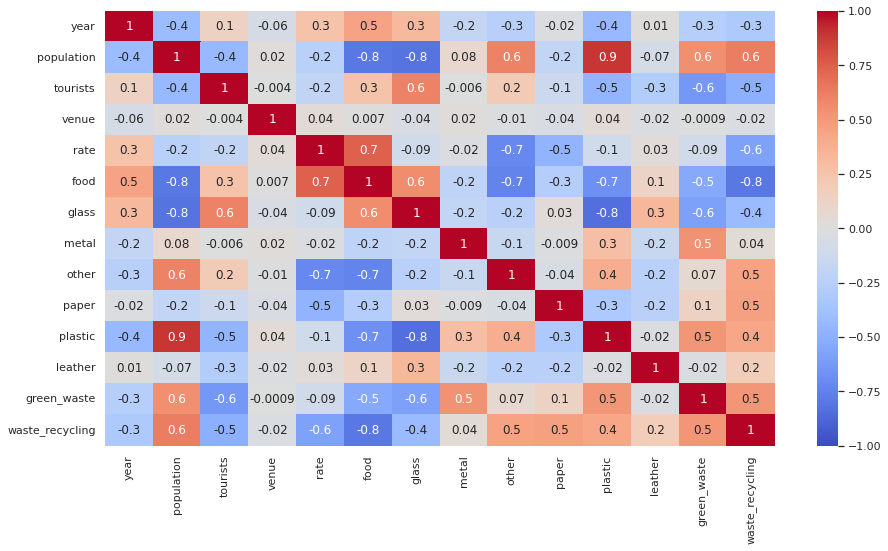

In [ ]:
seaborn.set(rc = {'figure.figsize':(15,8)})
seaborn.heatmap(concated.corr(), 
                fmt='.1g', 
                annot = True, 
                vmin=-1, 
                vmax=1, 
                center= 0, 
                cmap= 'coolwarm', 
                cbar=True
                )

Однозначных, кроме прямопропорциональной зависимости содержания пластика в водоёме от населения в стране и содержания стекла от количества туристов, замечено не было.
Зато мы видим, что содержание пищевых отходов и стекла от населения почти не зависит (что является очень сомнительным).

Таким образом, к сожаления, корреляционная матрица нам не дала какой-либо интересной и полезной информации.

Перейдём к предварительной обработке данных. Для начала генератором создадим списки категориальных и числовых столбцов:

In [ ]:
cat_col = [col_name for col_name in concated.columns if concated[col_name].dtypes == object]
num_col = [col_name for col_name in concated.columns if concated[col_name].dtypes != object]

cat_col, num_col, len(cat_col), len(num_col)

(['code', 'period', 'id', 'Country'],
 ['year',
  'population',
  'tourists',
  'venue',
  'rate',
  'food',
  'glass',
  'metal',
  'other',
  'paper',
  'plastic',
  'leather',
  'green_waste',
  'waste_recycling'],
 4,
 14)

Для категориальных столбцов используем метод get_dummies() из импортированной библиотеки pandas. Это позволит превратить категориальные данные (которые непонятны для модели) в бинарные:

In [ ]:
hotEncoded = pandas.get_dummies(concated[cat_col])

In [ ]:
hotEncoded

,code_EEA_3161-01-1,code_EEA_3161-02-2,code_EEA_3161-03-3,code_EEA_3161-05-5,code_EEA_31615-01-7,period_2006-01--2006-12,period_2007-01--2007-12,period_2007-12--2008-02,period_2008-01--2008-12,period_2008-03--2008-05,...,Country_Finland,Country_France,Country_Germany,Country_Latvia,Country_Lithuania,Country_Luxembourg,Country_Serbia,Country_Spain,Country_Sweden,Country_United Kingdom
index,,,,,,,,,,,,,,,,,,,,,
19,1,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
20,0,0,0,1,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
27,1,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
28,0,0,0,1,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
49,1,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19438,0,1,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
19462,0,1,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
19625,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


Для числовых столбцов применим min/max нормализацию из модуля preprocessing:

In [ ]:
x = concated[num_col].values
min_max_scaler = preprocessing.MinMaxScaler()
norm = min_max_scaler.fit_transform(x)
norm = pandas.DataFrame(norm, columns=num_col)

In [ ]:
norm

,year,population,tourists,venue,rate,food,glass,metal,other,paper,plastic,leather,green_waste,waste_recycling
0,0.333333,0.289927,1.000000,0.428571,0.0,0.511775,0.406250,0.207161,0.590238,0.438071,0.402667,0.0,0.000000,0.456767
1,0.333333,0.289927,1.000000,0.428571,0.0,0.511775,0.406250,0.207161,0.590238,0.438071,0.402667,0.0,0.000000,0.456767
2,0.333333,0.289927,1.000000,0.428571,0.0,0.511775,0.406250,0.207161,0.590238,0.438071,0.402667,0.0,0.000000,0.456767
3,0.333333,0.289927,1.000000,0.428571,0.0,0.511775,0.406250,0.207161,0.590238,0.438071,0.402667,0.0,0.000000,0.456767
4,0.333333,0.289927,1.000000,0.714286,0.0,0.511775,0.406250,0.207161,0.590238,0.438071,0.402667,0.0,0.000000,0.456767
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2194,0.444444,0.289927,1.000000,0.000000,0.0,0.511775,0.406250,0.207161,0.590238,0.438071,0.402667,0.0,0.000000,0.456767
2195,0.444444,0.289927,1.000000,0.000000,0.0,0.511775,0.406250,0.207161,0.590238,0.438071,0.402667,0.0,0.000000,0.456767
2196,0.333333,0.714193,0.358659,0.000000,0.0,0.072372,0.000000,0.271100,0.640182,0.403404,1.000000,0.0,0.176125,0.562779
2197,0.444444,0.210251,0.713578,0.000000,1.0,1.000000,0.302083,0.207161,0.317821,0.280492,0.402667,0.0,0.000000,0.341619


На этом этапе у нас есть два датафрейма: hotEncoded, содержащий бинарные данные и norm, содержащий нормализованные числовые данные. Чтобы объединить их без проблем добавим в оба датафрейма колонку ID, созданную генератором списков:

In [ ]:
norm['ID'] = [i for i in range(0, norm['year'].count())]

hotEncoded['ID'] = [i for i in range(0, hotEncoded['code_EEA_3161-01-1'].count())]

In [ ]:
norm

,year,population,tourists,venue,rate,food,glass,metal,other,paper,plastic,leather,green_waste,waste_recycling,ID
0,0.333333,0.289927,1.000000,0.428571,0.0,0.511775,0.406250,0.207161,0.590238,0.438071,0.402667,0.0,0.000000,0.456767,0
1,0.333333,0.289927,1.000000,0.428571,0.0,0.511775,0.406250,0.207161,0.590238,0.438071,0.402667,0.0,0.000000,0.456767,1
2,0.333333,0.289927,1.000000,0.428571,0.0,0.511775,0.406250,0.207161,0.590238,0.438071,0.402667,0.0,0.000000,0.456767,2
3,0.333333,0.289927,1.000000,0.428571,0.0,0.511775,0.406250,0.207161,0.590238,0.438071,0.402667,0.0,0.000000,0.456767,3
4,0.333333,0.289927,1.000000,0.714286,0.0,0.511775,0.406250,0.207161,0.590238,0.438071,0.402667,0.0,0.000000,0.456767,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2194,0.444444,0.289927,1.000000,0.000000,0.0,0.511775,0.406250,0.207161,0.590238,0.438071,0.402667,0.0,0.000000,0.456767,2194
2195,0.444444,0.289927,1.000000,0.000000,0.0,0.511775,0.406250,0.207161,0.590238,0.438071,0.402667,0.0,0.000000,0.456767,2195
2196,0.333333,0.714193,0.358659,0.000000,0.0,0.072372,0.000000,0.271100,0.640182,0.403404,1.000000,0.0,0.176125,0.562779,2196
2197,0.444444,0.210251,0.713578,0.000000,1.0,1.000000,0.302083,0.207161,0.317821,0.280492,0.402667,0.0,0.000000,0.341619,2197


In [ ]:
hotEncoded

,code_EEA_3161-01-1,code_EEA_3161-02-2,code_EEA_3161-03-3,code_EEA_3161-05-5,code_EEA_31615-01-7,period_2006-01--2006-12,period_2007-01--2007-12,period_2007-12--2008-02,period_2008-01--2008-12,period_2008-03--2008-05,...,Country_France,Country_Germany,Country_Latvia,Country_Lithuania,Country_Luxembourg,Country_Serbia,Country_Spain,Country_Sweden,Country_United Kingdom,ID
index,,,,,,,,,,,,,,,,,,,,,
19,1,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
20,0,0,0,1,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,1
27,1,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,2
28,0,0,0,1,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,3
49,1,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19438,0,1,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,2194
19462,0,1,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,2195
19625,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,2196


Для объединения двух датафреймов используем метод join со следующими параметрами:


1.   on - колонка с общими данными, на основании которых будет происходить объединение (в нашем случае - колонка ID);
2.   how - каким образом происходит объединение;
3.   lsuffix - в случае пересечения названий колонок, к названиям из "левого" датафрейма будет добавлено "_left" (например, "name_left");
4.   rsuffix - в случае пересечения названий колонок, к названиям из "правого" датафрейма будет добавлено "_right" (например, "name_right").



In [ ]:
concated = hotEncoded.join(norm, on='ID', how='outer', lsuffix='_left')

In [ ]:
concated

,code_EEA_3161-01-1,code_EEA_3161-02-2,code_EEA_3161-03-3,code_EEA_3161-05-5,code_EEA_31615-01-7,period_2006-01--2006-12,period_2007-01--2007-12,period_2007-12--2008-02,period_2008-01--2008-12,period_2008-03--2008-05,...,food,glass,metal,other,paper,plastic,leather,green_waste,waste_recycling,ID
index,,,,,,,,,,,,,,,,,,,,,
19,1,0,0,0,0,0,0,0,0,0,...,0.511775,0.406250,0.207161,0.590238,0.438071,0.402667,0.0,0.000000,0.456767,0
20,0,0,0,1,0,0,0,0,0,0,...,0.511775,0.406250,0.207161,0.590238,0.438071,0.402667,0.0,0.000000,0.456767,1
27,1,0,0,0,0,0,0,0,0,0,...,0.511775,0.406250,0.207161,0.590238,0.438071,0.402667,0.0,0.000000,0.456767,2
28,0,0,0,1,0,0,0,0,0,0,...,0.511775,0.406250,0.207161,0.590238,0.438071,0.402667,0.0,0.000000,0.456767,3
49,1,0,0,0,0,0,0,0,0,0,...,0.511775,0.406250,0.207161,0.590238,0.438071,0.402667,0.0,0.000000,0.456767,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19438,0,1,0,0,0,0,0,0,0,0,...,0.511775,0.406250,0.207161,0.590238,0.438071,0.402667,0.0,0.000000,0.456767,2194
19462,0,1,0,0,0,0,0,0,0,0,...,0.511775,0.406250,0.207161,0.590238,0.438071,0.402667,0.0,0.000000,0.456767,2195
19625,0,1,0,0,0,0,0,0,0,0,...,0.072372,0.000000,0.271100,0.640182,0.403404,1.000000,0.0,0.176125,0.562779,2196


После того, как обработали данные, нужно обратно разделить датафрейм concated на тестовый и тренировочный датарфеймы с тем же количеством строк, сколько содержалось в trainDF и testDF соответственно:

In [ ]:
train = concated.iloc[0:trainDF.shape[0],:]
test = concated.iloc[trainDF.shape[0]:,:]

Проверим, всё ли правильно распределилось:

In [ ]:
train.shape[0], trainDF.shape[0], test.shape[0], testDF.shape[0]

(1979, 1979, 220, 220)

# 3. Обучение модели и результирующее предсказание.

Далее разделим тренировочный датафрейм и наш таргет на тестовые и валидационные выборки классом train_test_split(),

In [ ]:
X_train_, X_val, y_train_, y_val = train_test_split(train, target, test_size = 0.3, random_state = 42)

Затем вызовем класс LinearRegression() и обучим нашу модель на тестовых выборках:

In [ ]:
linregr = LinearRegression()

linregr.fit(X_train_, y_train_)

LinearRegression()

Сделаем "предсказание":

In [ ]:
predict = linregr.predict(X_val)
X_val['orig'] = y_val
X_val['pred'] = predict

X_val

,code_EEA_3161-01-1,code_EEA_3161-02-2,code_EEA_3161-03-3,code_EEA_3161-05-5,code_EEA_31615-01-7,period_2006-01--2006-12,period_2007-01--2007-12,period_2007-12--2008-02,period_2008-01--2008-12,period_2008-03--2008-05,...,metal,other,paper,plastic,leather,green_waste,waste_recycling,ID,orig,pred
index,,,,,,,,,,,,,,,,,,,,,
4260,0,1,0,0,0,0,0,0,0,0,...,0.207161,0.590238,0.438071,0.402667,0.0,0.0,0.456767,567,1.027668,1.221017
806,1,0,0,0,0,0,0,0,0,0,...,0.207161,0.590238,0.438071,0.402667,0.0,0.0,0.456767,99,0.650588,0.686657
8625,1,0,0,0,0,0,0,0,0,0,...,0.207161,0.590238,0.438071,0.402667,0.0,0.0,0.456767,1053,0.464782,1.016625
15903,0,0,0,0,1,0,0,0,0,0,...,0.207161,0.317821,0.280492,0.402667,0.0,0.0,0.341619,1679,0.986227,1.313501
13846,0,1,0,0,0,0,0,0,0,0,...,0.156010,0.220204,0.000000,0.333333,0.9,0.0,0.434884,1506,1.048956,1.036980
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13826,0,1,0,0,0,0,0,0,0,0,...,0.207161,0.590238,0.438071,0.402667,0.0,0.0,0.456767,1498,0.789216,1.230879
14355,0,0,0,1,0,0,0,0,0,0,...,0.207161,0.590238,0.438071,0.402667,0.0,0.0,0.456767,1547,0.950008,1.119309
1930,0,0,1,0,0,0,0,0,0,0,...,0.207161,0.590238,0.438071,0.402667,0.0,0.0,0.456767,286,0.748364,0.183526


Посмотрим среднеквадратическую ошибку и среднеквадратическое отклонение:

In [ ]:
mse = mean_squared_error(y_val, predict)
msd = math.sqrt(mse)

mse, msd

(0.14538096277926452, 0.38128855579372495)

Значения ошибки и отклонения не являются существенными, потому можем преступить к предсказанию на тестовом датафрейме:

In [ ]:
pred = linregr.predict(test)

In [ ]:
submission['polution'] = pred

In [ ]:
submission

,polution
index,
202,1.245836
395,0.701396
725,1.470066
770,1.455013
771,1.264300
...,...
19438,2.057690
19462,1.525887
19625,0.021290


Сохраняем результат в csv-файл и загружаем его в каггл:

In [ ]:
submission.to_csv('/content/My_Submission.csv',index=True)

In [ ]:
!kaggle competitions submit -c urfu-engai-ml-2022-regression -f My_Submission.csv -m 'Final'

100% 5.27k/5.27k [00:00<00:00, 9.10kB/s]
Successfully submitted to UrFU_EngAI_ML_2022_Regression

Итоговая метрика: 0.668, т.е. совпадение предсказания и реальных значений около 67%.